In [37]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt 
import numpy as np
import PIL
import time
from IPython import display

In [38]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()   #读取mnist数据集

In [39]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')   #图像尺寸、类型转换
x_train = x_train[0:10000]   #选用前10000张作为训练集
x_train = x_train/255.0   #数据归一化

In [40]:
print(x_train.shape)

(10000, 28, 28, 1)


In [41]:
buffer_size = 30000
batch_size = 256   #一批次有256张图像

In [42]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)   #打乱数据集并分批

In [43]:
class DCGAN(tf.keras.Model):
    def __init__(self):
        super(DCGAN,self).__init__()
        self.Generator = tf.keras.models.Sequential([   #生成器网络
            layers.Dense(7*7*256),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Reshape((7,7,256)),
            layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',activation='tanh'),
        ])
        self.Discriminator = tf.keras.models.Sequential([   #判别器网络
            layers.Conv2D(64,(5,5),strides=(2,2),padding='same'),
            layers.LeakyReLU(),
            layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(),
            layers.Flatten(),
            layers.Dense(1)
        ])

In [44]:
DCGAN = DCGAN()   #模型创建

In [45]:
z_distribution = tf.random.normal([1, 100])   #创建长度为1x100的随机正态分布向量

In [46]:
generated_image = DCGAN.Generator(z_distribution,training=False)   #调用生成器

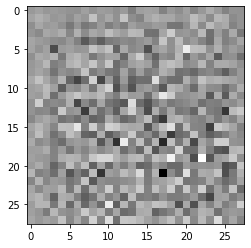

In [47]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')   #查看生成的图片

In [48]:
dis_result = DCGAN.Discriminator(generated_image)   #调用判别器
print(dis_result)   #查看判别结果

tf.Tensor([[-0.00288183]], shape=(1, 1), dtype=float32)


In [49]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)   #调用损失函数

In [50]:
def discriminator_loss(real_output,fake_output):   #判别器损失函数
    #真实样本给予全1标签
    real_loss = binary_cross_entropy(tf.ones_like(real_output),real_output)   
    #生成样本给予全0标签
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output),fake_output)   
    total_loss = real_loss + fake_loss   #损失函数为以上二者之和
    return total_loss

In [51]:
def generator_loss(fake_output):   #生成器损失函数
    return binary_cross_entropy(tf.ones_like(fake_output),fake_output)   #生成样本给予全1标签

In [52]:
epochs = 60   #训练次数
z_distribution_dim = 100   #隐变量维度
generate_numbers = 12   #生成样本的数量
seed = tf.random.normal([generate_numbers, z_distribution_dim])   #用于测试的随机向量

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [54]:
def train_step(images,step):
    z_distribution = tf.random.normal([batch_size, z_distribution_dim])   #定义输入生成器的随机向量
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = DCGAN.Generator(z_distribution, training=True)   #生成图片
        #对真实样本进行判别
        real_output = DCGAN.Discriminator(images, training=True)
        #对生成样本进行判别
        fake_output = DCGAN.Discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)   #计算生成器损失
        disc_loss = discriminator_loss(real_output, fake_output)   #计算判别器损失
    #输出生成器和判别器的损失值
    print('Generator step {} loss is {}'.format(step,gen_loss))
    print('Discriminator step {} loss is {}'.format(step,disc_loss))
    #计算生成器和判别器的梯度并进行更新
    gradients_of_generator = gen_tape.gradient(gen_loss, DCGAN.Generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, DCGAN.Discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, DCGAN.Generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, DCGAN.Discriminator.trainable_variables))

In [55]:
def generate_images(model,test_input):
    predictions = model(test_input, training=False)    #对seed变量输入进行预测
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):   #查看生成的图像，显示12张
        plt.subplot(3, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')
    plt.show()

In [56]:
def train(dataset, epochs):   #DCGAN模型训练函数
    for epoch in range(epochs):
        print("epoch:{}".format(epoch))
        step = 0   #记录在一次训练里的批次数
        start = time.time()
        for image_batch in dataset:   #逐批训练
            train_step(image_batch,step)
            step += 1
        print('Time for epoch {} is {} sec'.format(epoch,time.time()-start))   #训练一次的时间
        generate_images(DCGAN.Generator,seed)   #显示生成图像的变化

epoch:0
Generator step 0 loss is 0.7145646214485168
Discriminator step 0 loss is 1.3695259094238281
Generator step 1 loss is 0.7078595161437988
Discriminator step 1 loss is 1.3664884567260742
Generator step 2 loss is 0.7053114771842957
Discriminator step 2 loss is 1.3590805530548096
Generator step 3 loss is 0.7030126452445984
Discriminator step 3 loss is 1.3525038957595825
Generator step 4 loss is 0.7019749283790588
Discriminator step 4 loss is 1.3440223932266235
Generator step 5 loss is 0.7010701298713684
Discriminator step 5 loss is 1.3393850326538086
Generator step 6 loss is 0.7016545534133911
Discriminator step 6 loss is 1.3289623260498047
Generator step 7 loss is 0.7034330368041992
Discriminator step 7 loss is 1.318274974822998
Generator step 8 loss is 0.704522430896759
Discriminator step 8 loss is 1.3110860586166382
Generator step 9 loss is 0.7021980285644531
Discriminator step 9 loss is 1.3071084022521973
Generator step 10 loss is 0.6985713839530945
Discriminator step 10 loss is

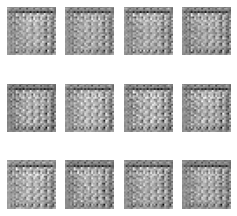

epoch:1
Generator step 0 loss is 0.806751012802124
Discriminator step 0 loss is 1.1867215633392334
Generator step 1 loss is 0.817558765411377
Discriminator step 1 loss is 1.1838316917419434
Generator step 2 loss is 0.8261962532997131
Discriminator step 2 loss is 1.1798574924468994
Generator step 3 loss is 0.8341687321662903
Discriminator step 3 loss is 1.1802031993865967
Generator step 4 loss is 0.8402432799339294
Discriminator step 4 loss is 1.1752873659133911
Generator step 5 loss is 0.8449721336364746
Discriminator step 5 loss is 1.1784498691558838
Generator step 6 loss is 0.8454387187957764
Discriminator step 6 loss is 1.1871109008789062
Generator step 7 loss is 0.8427138924598694
Discriminator step 7 loss is 1.1923813819885254
Generator step 8 loss is 0.836929440498352
Discriminator step 8 loss is 1.2000253200531006
Generator step 9 loss is 0.8265010714530945
Discriminator step 9 loss is 1.2134958505630493
Generator step 10 loss is 0.8119107484817505
Discriminator step 10 loss is 

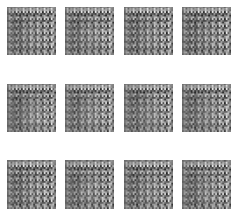

epoch:2
Generator step 0 loss is 1.280556082725525
Discriminator step 0 loss is 0.9869613647460938
Generator step 1 loss is 1.2976126670837402
Discriminator step 1 loss is 0.9729742407798767
Generator step 2 loss is 1.3145177364349365
Discriminator step 2 loss is 0.9626182317733765
Generator step 3 loss is 1.3324964046478271
Discriminator step 3 loss is 0.9565452337265015
Generator step 4 loss is 1.3502379655838013
Discriminator step 4 loss is 0.9387182593345642
Generator step 5 loss is 1.367948293685913
Discriminator step 5 loss is 0.9295704364776611
Generator step 6 loss is 1.3816299438476562
Discriminator step 6 loss is 0.9343847036361694
Generator step 7 loss is 1.392274022102356
Discriminator step 7 loss is 0.92999267578125
Generator step 8 loss is 1.4024076461791992
Discriminator step 8 loss is 0.9166481494903564
Generator step 9 loss is 1.4073388576507568
Discriminator step 9 loss is 0.9171689748764038
Generator step 10 loss is 1.4103260040283203
Discriminator step 10 loss is 0.

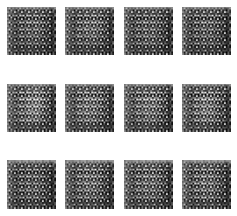

epoch:3
Generator step 0 loss is 1.6530482769012451
Discriminator step 0 loss is 0.7372441291809082
Generator step 1 loss is 1.6554847955703735
Discriminator step 1 loss is 0.720979630947113
Generator step 2 loss is 1.6501213312149048
Discriminator step 2 loss is 0.7229829430580139
Generator step 3 loss is 1.646881341934204
Discriminator step 3 loss is 0.7234295606613159
Generator step 4 loss is 1.639183521270752
Discriminator step 4 loss is 0.7072209119796753
Generator step 5 loss is 1.637697696685791
Discriminator step 5 loss is 0.7027187347412109
Generator step 6 loss is 1.623207926750183
Discriminator step 6 loss is 0.7074652314186096
Generator step 7 loss is 1.6119146347045898
Discriminator step 7 loss is 0.7081893682479858
Generator step 8 loss is 1.5851666927337646
Discriminator step 8 loss is 0.7079123258590698
Generator step 9 loss is 1.549338459968567
Discriminator step 9 loss is 0.695305347442627
Generator step 10 loss is 1.5126125812530518
Discriminator step 10 loss is 0.71

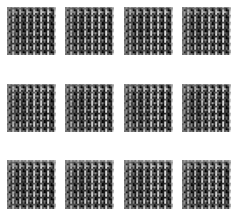

epoch:4
Generator step 0 loss is 2.093317747116089
Discriminator step 0 loss is 0.5696699023246765
Generator step 1 loss is 2.13633131980896
Discriminator step 1 loss is 0.5793116688728333
Generator step 2 loss is 2.1606643199920654
Discriminator step 2 loss is 0.5871274471282959
Generator step 3 loss is 2.1611080169677734
Discriminator step 3 loss is 0.5526027679443359
Generator step 4 loss is 2.136395215988159
Discriminator step 4 loss is 0.5615096092224121
Generator step 5 loss is 2.099782943725586
Discriminator step 5 loss is 0.5401583313941956
Generator step 6 loss is 2.0425543785095215
Discriminator step 6 loss is 0.5562259554862976
Generator step 7 loss is 1.9879237413406372
Discriminator step 7 loss is 0.5634787082672119
Generator step 8 loss is 1.918205976486206
Discriminator step 8 loss is 0.573176383972168
Generator step 9 loss is 1.8497222661972046
Discriminator step 9 loss is 0.5635461807250977
Generator step 10 loss is 1.7861297130584717
Discriminator step 10 loss is 0.57

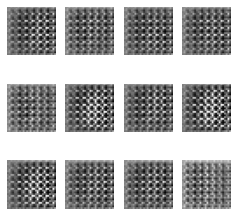

epoch:5
Generator step 0 loss is 1.3957679271697998
Discriminator step 0 loss is 0.9999858140945435
Generator step 1 loss is 1.419810175895691
Discriminator step 1 loss is 1.0117506980895996
Generator step 2 loss is 1.4350218772888184
Discriminator step 2 loss is 1.0367372035980225
Generator step 3 loss is 1.3951315879821777
Discriminator step 3 loss is 1.036824107170105
Generator step 4 loss is 1.4183964729309082
Discriminator step 4 loss is 0.9962519407272339
Generator step 5 loss is 1.3443104028701782
Discriminator step 5 loss is 1.0478096008300781
Generator step 6 loss is 1.2997664213180542
Discriminator step 6 loss is 1.0326203107833862
Generator step 7 loss is 1.3203957080841064
Discriminator step 7 loss is 0.9785089492797852
Generator step 8 loss is 1.2160930633544922
Discriminator step 8 loss is 1.0246405601501465
Generator step 9 loss is 1.201642632484436
Discriminator step 9 loss is 1.0595250129699707
Generator step 10 loss is 1.1748629808425903
Discriminator step 10 loss is 

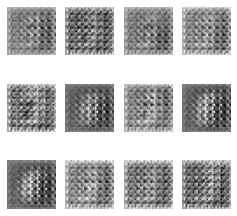

epoch:6
Generator step 0 loss is 1.3421341180801392
Discriminator step 0 loss is 0.8708151578903198
Generator step 1 loss is 1.3069148063659668
Discriminator step 1 loss is 0.8913547992706299
Generator step 2 loss is 1.2635407447814941
Discriminator step 2 loss is 0.9239428639411926
Generator step 3 loss is 1.225684404373169
Discriminator step 3 loss is 0.9295044541358948
Generator step 4 loss is 1.2163275480270386
Discriminator step 4 loss is 0.8934892416000366
Generator step 5 loss is 1.1727244853973389
Discriminator step 5 loss is 0.9308161735534668
Generator step 6 loss is 1.1017746925354004
Discriminator step 6 loss is 0.9851338863372803
Generator step 7 loss is 1.0839543342590332
Discriminator step 7 loss is 0.9667848348617554
Generator step 8 loss is 1.0918458700180054
Discriminator step 8 loss is 0.9484790563583374
Generator step 9 loss is 1.0728024244308472
Discriminator step 9 loss is 0.9937565326690674
Generator step 10 loss is 1.0672842264175415
Discriminator step 10 loss i

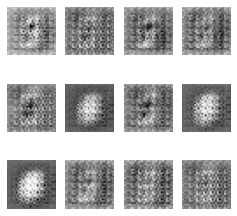

epoch:7
Generator step 0 loss is 0.825797975063324
Discriminator step 0 loss is 1.1189885139465332
Generator step 1 loss is 0.8286258578300476
Discriminator step 1 loss is 1.1453726291656494
Generator step 2 loss is 0.825104832649231
Discriminator step 2 loss is 1.15198814868927
Generator step 3 loss is 0.8047386407852173
Discriminator step 3 loss is 1.184680461883545
Generator step 4 loss is 0.7994197607040405
Discriminator step 4 loss is 1.1378357410430908
Generator step 5 loss is 0.7842822074890137
Discriminator step 5 loss is 1.1443699598312378
Generator step 6 loss is 0.7837889790534973
Discriminator step 6 loss is 1.135657548904419
Generator step 7 loss is 0.7733726501464844
Discriminator step 7 loss is 1.1686450242996216
Generator step 8 loss is 0.7682000994682312
Discriminator step 8 loss is 1.1519441604614258
Generator step 9 loss is 0.7625528573989868
Discriminator step 9 loss is 1.1901037693023682
Generator step 10 loss is 0.7638428211212158
Discriminator step 10 loss is 1.1

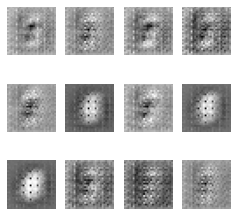

epoch:8
Generator step 0 loss is 0.7972788214683533
Discriminator step 0 loss is 1.078621745109558
Generator step 1 loss is 0.7953447699546814
Discriminator step 1 loss is 1.0767810344696045
Generator step 2 loss is 0.8012980222702026
Discriminator step 2 loss is 1.058499813079834
Generator step 3 loss is 0.7981444001197815
Discriminator step 3 loss is 1.08943510055542
Generator step 4 loss is 0.805400013923645
Discriminator step 4 loss is 1.0765893459320068
Generator step 5 loss is 0.8007374405860901
Discriminator step 5 loss is 1.068158507347107
Generator step 6 loss is 0.8037517070770264
Discriminator step 6 loss is 1.0619033575057983
Generator step 7 loss is 0.8056442141532898
Discriminator step 7 loss is 1.0652694702148438
Generator step 8 loss is 0.8035091757774353
Discriminator step 8 loss is 1.0644081830978394
Generator step 9 loss is 0.8001911044120789
Discriminator step 9 loss is 1.0648260116577148
Generator step 10 loss is 0.796470046043396
Discriminator step 10 loss is 1.06

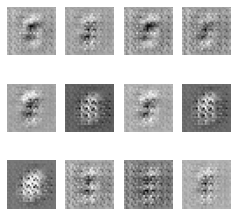

epoch:9
Generator step 0 loss is 0.7651023864746094
Discriminator step 0 loss is 1.0902304649353027
Generator step 1 loss is 0.7508462071418762
Discriminator step 1 loss is 1.0637656450271606
Generator step 2 loss is 0.7147303223609924
Discriminator step 2 loss is 1.0735429525375366
Generator step 3 loss is 0.6932166814804077
Discriminator step 3 loss is 1.0941828489303589
Generator step 4 loss is 0.6777001619338989
Discriminator step 4 loss is 1.1045918464660645
Generator step 5 loss is 0.6622166633605957
Discriminator step 5 loss is 1.1150951385498047
Generator step 6 loss is 0.6540900468826294
Discriminator step 6 loss is 1.1670715808868408
Generator step 7 loss is 0.6548734903335571
Discriminator step 7 loss is 1.1581449508666992
Generator step 8 loss is 0.6661997437477112
Discriminator step 8 loss is 1.1667115688323975
Generator step 9 loss is 0.6844826936721802
Discriminator step 9 loss is 1.1559545993804932
Generator step 10 loss is 0.6910184621810913
Discriminator step 10 loss 

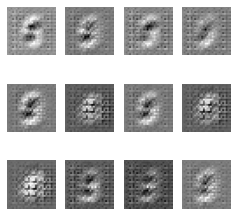

epoch:10
Generator step 0 loss is 0.9196239709854126
Discriminator step 0 loss is 1.1232503652572632
Generator step 1 loss is 0.9041438102722168
Discriminator step 1 loss is 1.1183488368988037
Generator step 2 loss is 0.893332302570343
Discriminator step 2 loss is 1.1185173988342285
Generator step 3 loss is 0.8998710513114929
Discriminator step 3 loss is 1.1211504936218262
Generator step 4 loss is 0.8966733813285828
Discriminator step 4 loss is 1.1244468688964844
Generator step 5 loss is 0.9079521894454956
Discriminator step 5 loss is 1.1155321598052979
Generator step 6 loss is 0.9220161437988281
Discriminator step 6 loss is 1.1266610622406006
Generator step 7 loss is 0.943207859992981
Discriminator step 7 loss is 1.1054695844650269
Generator step 8 loss is 0.9701563119888306
Discriminator step 8 loss is 1.1083728075027466
Generator step 9 loss is 0.9710633754730225
Discriminator step 9 loss is 1.108198881149292
Generator step 10 loss is 0.9871426224708557
Discriminator step 10 loss is

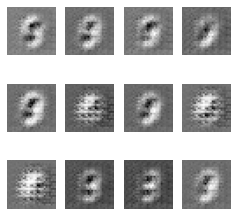

epoch:11
Generator step 0 loss is 0.681675910949707
Discriminator step 0 loss is 1.4920775890350342
Generator step 1 loss is 0.6873986124992371
Discriminator step 1 loss is 1.4904240369796753
Generator step 2 loss is 0.7071527242660522
Discriminator step 2 loss is 1.4552830457687378
Generator step 3 loss is 0.7221225500106812
Discriminator step 3 loss is 1.476611852645874
Generator step 4 loss is 0.7381818890571594
Discriminator step 4 loss is 1.441474199295044
Generator step 5 loss is 0.7607080936431885
Discriminator step 5 loss is 1.4576812982559204
Generator step 6 loss is 0.7857253551483154
Discriminator step 6 loss is 1.4736533164978027
Generator step 7 loss is 0.8062789440155029
Discriminator step 7 loss is 1.4194278717041016
Generator step 8 loss is 0.8313615322113037
Discriminator step 8 loss is 1.372509479522705
Generator step 9 loss is 0.8298109769821167
Discriminator step 9 loss is 1.3535635471343994
Generator step 10 loss is 0.8488919734954834
Discriminator step 10 loss is 

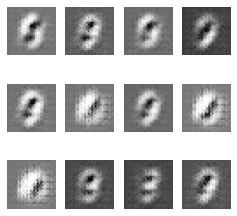

epoch:12
Generator step 0 loss is 0.7280136942863464
Discriminator step 0 loss is 1.344780683517456
Generator step 1 loss is 0.7285504341125488
Discriminator step 1 loss is 1.3551756143569946
Generator step 2 loss is 0.7405139207839966
Discriminator step 2 loss is 1.3417117595672607
Generator step 3 loss is 0.7401626706123352
Discriminator step 3 loss is 1.355120301246643
Generator step 4 loss is 0.7480140328407288
Discriminator step 4 loss is 1.3176701068878174
Generator step 5 loss is 0.7547179460525513
Discriminator step 5 loss is 1.3411576747894287
Generator step 6 loss is 0.7587222456932068
Discriminator step 6 loss is 1.3407286405563354
Generator step 7 loss is 0.756969690322876
Discriminator step 7 loss is 1.3176648616790771
Generator step 8 loss is 0.7497328519821167
Discriminator step 8 loss is 1.3432202339172363
Generator step 9 loss is 0.7384834885597229
Discriminator step 9 loss is 1.3074712753295898
Generator step 10 loss is 0.7427341938018799
Discriminator step 10 loss is

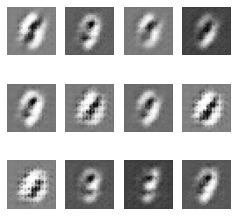

epoch:13
Generator step 0 loss is 0.7408832311630249
Discriminator step 0 loss is 1.3921442031860352
Generator step 1 loss is 0.7431496381759644
Discriminator step 1 loss is 1.3947670459747314
Generator step 2 loss is 0.7643412351608276
Discriminator step 2 loss is 1.3746618032455444
Generator step 3 loss is 0.7783221006393433
Discriminator step 3 loss is 1.3609330654144287
Generator step 4 loss is 0.7836190462112427
Discriminator step 4 loss is 1.341416835784912
Generator step 5 loss is 0.7834587693214417
Discriminator step 5 loss is 1.3207957744598389
Generator step 6 loss is 0.7830801010131836
Discriminator step 6 loss is 1.345210313796997
Generator step 7 loss is 0.7888445258140564
Discriminator step 7 loss is 1.2910752296447754
Generator step 8 loss is 0.7742450833320618
Discriminator step 8 loss is 1.2768300771713257
Generator step 9 loss is 0.7656862139701843
Discriminator step 9 loss is 1.2595429420471191
Generator step 10 loss is 0.760240375995636
Discriminator step 10 loss is

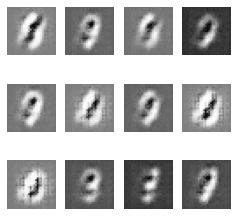

epoch:14
Generator step 0 loss is 0.6549713015556335
Discriminator step 0 loss is 1.3090816736221313
Generator step 1 loss is 0.6566741466522217
Discriminator step 1 loss is 1.3140473365783691
Generator step 2 loss is 0.6604862809181213
Discriminator step 2 loss is 1.3070670366287231
Generator step 3 loss is 0.6634308695793152
Discriminator step 3 loss is 1.2990949153900146
Generator step 4 loss is 0.6656725406646729
Discriminator step 4 loss is 1.3043208122253418
Generator step 5 loss is 0.6658027172088623
Discriminator step 5 loss is 1.3022164106369019
Generator step 6 loss is 0.6783219575881958
Discriminator step 6 loss is 1.285825252532959
Generator step 7 loss is 0.67812579870224
Discriminator step 7 loss is 1.2809438705444336
Generator step 8 loss is 0.6824902296066284
Discriminator step 8 loss is 1.2888226509094238
Generator step 9 loss is 0.688189685344696
Discriminator step 9 loss is 1.2774138450622559
Generator step 10 loss is 0.6879462599754333
Discriminator step 10 loss is 

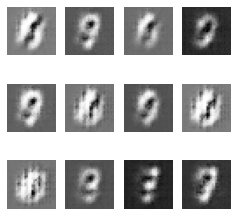

epoch:15
Generator step 0 loss is 0.7869688868522644
Discriminator step 0 loss is 1.2305731773376465
Generator step 1 loss is 0.7870729565620422
Discriminator step 1 loss is 1.2071192264556885
Generator step 2 loss is 0.7797770500183105
Discriminator step 2 loss is 1.229649305343628
Generator step 3 loss is 0.785407304763794
Discriminator step 3 loss is 1.1975736618041992
Generator step 4 loss is 0.7912985682487488
Discriminator step 4 loss is 1.1978448629379272
Generator step 5 loss is 0.8008342385292053
Discriminator step 5 loss is 1.2007508277893066
Generator step 6 loss is 0.8012893199920654
Discriminator step 6 loss is 1.1720786094665527
Generator step 7 loss is 0.8108619451522827
Discriminator step 7 loss is 1.175217866897583
Generator step 8 loss is 0.8125730752944946
Discriminator step 8 loss is 1.1868515014648438
Generator step 9 loss is 0.82757568359375
Discriminator step 9 loss is 1.1755774021148682
Generator step 10 loss is 0.8295629620552063
Discriminator step 10 loss is 1

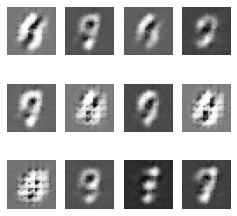

epoch:16
Generator step 0 loss is 0.7985090613365173
Discriminator step 0 loss is 1.1798335313796997
Generator step 1 loss is 0.7958999872207642
Discriminator step 1 loss is 1.1369273662567139
Generator step 2 loss is 0.7888500690460205
Discriminator step 2 loss is 1.1972670555114746
Generator step 3 loss is 0.791624903678894
Discriminator step 3 loss is 1.1559052467346191
Generator step 4 loss is 0.7858861088752747
Discriminator step 4 loss is 1.1642528772354126
Generator step 5 loss is 0.7861621975898743
Discriminator step 5 loss is 1.1632277965545654
Generator step 6 loss is 0.7833312749862671
Discriminator step 6 loss is 1.160876989364624
Generator step 7 loss is 0.7835922241210938
Discriminator step 7 loss is 1.152400255203247
Generator step 8 loss is 0.7847692370414734
Discriminator step 8 loss is 1.1728216409683228
Generator step 9 loss is 0.7970863580703735
Discriminator step 9 loss is 1.14682936668396
Generator step 10 loss is 0.7911374568939209
Discriminator step 10 loss is 1

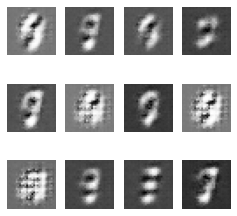

epoch:17
Generator step 0 loss is 0.8104419112205505
Discriminator step 0 loss is 1.1175353527069092
Generator step 1 loss is 0.8136806488037109
Discriminator step 1 loss is 1.105466604232788
Generator step 2 loss is 0.8188578486442566
Discriminator step 2 loss is 1.1088848114013672
Generator step 3 loss is 0.8155410885810852
Discriminator step 3 loss is 1.116441249847412
Generator step 4 loss is 0.8192135691642761
Discriminator step 4 loss is 1.0982060432434082
Generator step 5 loss is 0.8087856769561768
Discriminator step 5 loss is 1.1212712526321411
Generator step 6 loss is 0.820370614528656
Discriminator step 6 loss is 1.0978176593780518
Generator step 7 loss is 0.8155373930931091
Discriminator step 7 loss is 1.1070425510406494
Generator step 8 loss is 0.811484158039093
Discriminator step 8 loss is 1.1098017692565918
Generator step 9 loss is 0.8103933334350586
Discriminator step 9 loss is 1.1098737716674805
Generator step 10 loss is 0.816217303276062
Discriminator step 10 loss is 1

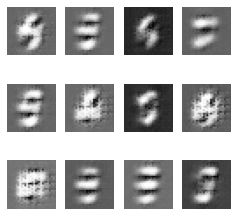

epoch:18
Generator step 0 loss is 0.8670353889465332
Discriminator step 0 loss is 1.1398097276687622
Generator step 1 loss is 0.8692331314086914
Discriminator step 1 loss is 1.143665075302124
Generator step 2 loss is 0.8782228231430054
Discriminator step 2 loss is 1.1531760692596436
Generator step 3 loss is 0.8858622312545776
Discriminator step 3 loss is 1.1288728713989258
Generator step 4 loss is 0.8879794478416443
Discriminator step 4 loss is 1.1297457218170166
Generator step 5 loss is 0.8950374722480774
Discriminator step 5 loss is 1.1240668296813965
Generator step 6 loss is 0.9280136823654175
Discriminator step 6 loss is 1.1184208393096924
Generator step 7 loss is 0.9311059713363647
Discriminator step 7 loss is 1.101107120513916
Generator step 8 loss is 0.9392489790916443
Discriminator step 8 loss is 1.0907163619995117
Generator step 9 loss is 0.9612448811531067
Discriminator step 9 loss is 1.09099543094635
Generator step 10 loss is 0.9632277488708496
Discriminator step 10 loss is 

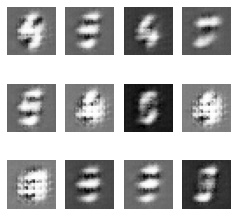

epoch:19
Generator step 0 loss is 0.869897186756134
Discriminator step 0 loss is 1.045127034187317
Generator step 1 loss is 0.8855758309364319
Discriminator step 1 loss is 1.0878880023956299
Generator step 2 loss is 0.8709840774536133
Discriminator step 2 loss is 1.1063352823257446
Generator step 3 loss is 0.8774614930152893
Discriminator step 3 loss is 1.1430726051330566
Generator step 4 loss is 0.8688096404075623
Discriminator step 4 loss is 1.148646593093872
Generator step 5 loss is 0.8670271039009094
Discriminator step 5 loss is 1.111616611480713
Generator step 6 loss is 0.8648722767829895
Discriminator step 6 loss is 1.1209156513214111
Generator step 7 loss is 0.8748297691345215
Discriminator step 7 loss is 1.1171698570251465
Generator step 8 loss is 0.8807977437973022
Discriminator step 8 loss is 1.1223523616790771
Generator step 9 loss is 0.8749784231185913
Discriminator step 9 loss is 1.0625689029693604
Generator step 10 loss is 0.8811922073364258
Discriminator step 10 loss is 

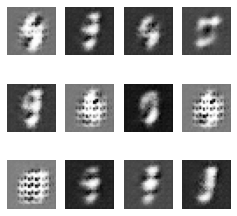

epoch:20
Generator step 0 loss is 0.8812310695648193
Discriminator step 0 loss is 1.200332760810852
Generator step 1 loss is 0.8855664730072021
Discriminator step 1 loss is 1.1709468364715576
Generator step 2 loss is 0.8927173018455505
Discriminator step 2 loss is 1.1681280136108398
Generator step 3 loss is 0.8950289487838745
Discriminator step 3 loss is 1.1585814952850342
Generator step 4 loss is 0.9090381860733032
Discriminator step 4 loss is 1.1012579202651978
Generator step 5 loss is 0.9358721971511841
Discriminator step 5 loss is 1.0674176216125488
Generator step 6 loss is 0.9606794118881226
Discriminator step 6 loss is 1.053016185760498
Generator step 7 loss is 0.9823459386825562
Discriminator step 7 loss is 1.0244297981262207
Generator step 8 loss is 1.0158882141113281
Discriminator step 8 loss is 0.9979956150054932
Generator step 9 loss is 1.036421537399292
Discriminator step 9 loss is 0.9793516993522644
Generator step 10 loss is 1.075645089149475
Discriminator step 10 loss is 

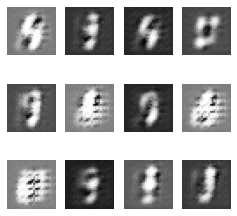

epoch:21
Generator step 0 loss is 0.9086012244224548
Discriminator step 0 loss is 1.1323833465576172
Generator step 1 loss is 0.8981168866157532
Discriminator step 1 loss is 1.107020616531372
Generator step 2 loss is 0.8946081399917603
Discriminator step 2 loss is 1.1239092350006104
Generator step 3 loss is 0.8797174692153931
Discriminator step 3 loss is 1.15146005153656
Generator step 4 loss is 0.8689004182815552
Discriminator step 4 loss is 1.1713345050811768
Generator step 5 loss is 0.8583387136459351
Discriminator step 5 loss is 1.1339538097381592
Generator step 6 loss is 0.8490910530090332
Discriminator step 6 loss is 1.1677762269973755
Generator step 7 loss is 0.8381192088127136
Discriminator step 7 loss is 1.1777043342590332
Generator step 8 loss is 0.8298872709274292
Discriminator step 8 loss is 1.1427947282791138
Generator step 9 loss is 0.8383253216743469
Discriminator step 9 loss is 1.1403782367706299
Generator step 10 loss is 0.8469880223274231
Discriminator step 10 loss is

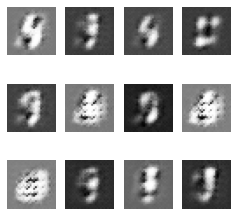

epoch:22
Generator step 0 loss is 1.0754345655441284
Discriminator step 0 loss is 0.8310513496398926
Generator step 1 loss is 1.0263761281967163
Discriminator step 1 loss is 0.8650397062301636
Generator step 2 loss is 1.0026583671569824
Discriminator step 2 loss is 0.8823256492614746
Generator step 3 loss is 0.9923141002655029
Discriminator step 3 loss is 0.8892233371734619
Generator step 4 loss is 0.9838531613349915
Discriminator step 4 loss is 0.9179064035415649
Generator step 5 loss is 0.9859048128128052
Discriminator step 5 loss is 0.9495601058006287
Generator step 6 loss is 0.9853059649467468
Discriminator step 6 loss is 0.9485418796539307
Generator step 7 loss is 0.9659639000892639
Discriminator step 7 loss is 0.9869300723075867
Generator step 8 loss is 0.952193021774292
Discriminator step 8 loss is 0.9830646514892578
Generator step 9 loss is 0.9503077268600464
Discriminator step 9 loss is 0.9806368947029114
Generator step 10 loss is 0.929227888584137
Discriminator step 10 loss i

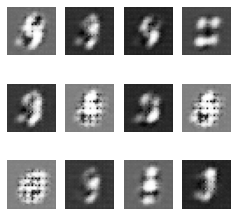

epoch:23
Generator step 0 loss is 1.0418431758880615
Discriminator step 0 loss is 0.8941113352775574
Generator step 1 loss is 1.0596840381622314
Discriminator step 1 loss is 0.8895605802536011
Generator step 2 loss is 1.0827138423919678
Discriminator step 2 loss is 0.8891911506652832
Generator step 3 loss is 1.1007627248764038
Discriminator step 3 loss is 0.873090386390686
Generator step 4 loss is 1.107391595840454
Discriminator step 4 loss is 0.8406941890716553
Generator step 5 loss is 1.1136072874069214
Discriminator step 5 loss is 0.8655998706817627
Generator step 6 loss is 1.0763394832611084
Discriminator step 6 loss is 0.8932644128799438
Generator step 7 loss is 1.0700302124023438
Discriminator step 7 loss is 0.8784288763999939
Generator step 8 loss is 1.0739368200302124
Discriminator step 8 loss is 0.8658324480056763
Generator step 9 loss is 1.076136589050293
Discriminator step 9 loss is 0.8516436815261841
Generator step 10 loss is 1.0565168857574463
Discriminator step 10 loss is

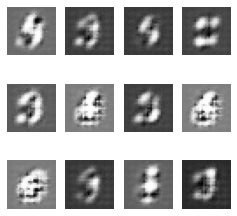

epoch:24
Generator step 0 loss is 0.8583903908729553
Discriminator step 0 loss is 1.0917651653289795
Generator step 1 loss is 0.8702710866928101
Discriminator step 1 loss is 1.119362473487854
Generator step 2 loss is 0.8607103824615479
Discriminator step 2 loss is 1.1127796173095703
Generator step 3 loss is 0.8601021766662598
Discriminator step 3 loss is 1.1108884811401367
Generator step 4 loss is 0.8497715592384338
Discriminator step 4 loss is 1.1352412700653076
Generator step 5 loss is 0.8235421180725098
Discriminator step 5 loss is 1.1167685985565186
Generator step 6 loss is 0.8132404088973999
Discriminator step 6 loss is 1.117404580116272
Generator step 7 loss is 0.798995316028595
Discriminator step 7 loss is 1.1376646757125854
Generator step 8 loss is 0.8090866804122925
Discriminator step 8 loss is 1.0990824699401855
Generator step 9 loss is 0.8023650050163269
Discriminator step 9 loss is 1.1116995811462402
Generator step 10 loss is 0.8246845006942749
Discriminator step 10 loss is

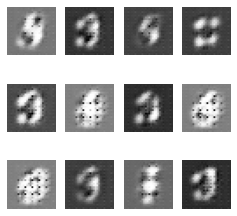

epoch:25
Generator step 0 loss is 1.3085439205169678
Discriminator step 0 loss is 0.7476509809494019
Generator step 1 loss is 1.3094340562820435
Discriminator step 1 loss is 0.7412865161895752
Generator step 2 loss is 1.3650710582733154
Discriminator step 2 loss is 0.7141600847244263
Generator step 3 loss is 1.3360337018966675
Discriminator step 3 loss is 0.7402397394180298
Generator step 4 loss is 1.2957110404968262
Discriminator step 4 loss is 0.7238414287567139
Generator step 5 loss is 1.276834487915039
Discriminator step 5 loss is 0.7208534479141235
Generator step 6 loss is 1.269046425819397
Discriminator step 6 loss is 0.7342932820320129
Generator step 7 loss is 1.2487208843231201
Discriminator step 7 loss is 0.7261401414871216
Generator step 8 loss is 1.2561321258544922
Discriminator step 8 loss is 0.7341018915176392
Generator step 9 loss is 1.2581530809402466
Discriminator step 9 loss is 0.735883355140686
Generator step 10 loss is 1.2634797096252441
Discriminator step 10 loss is

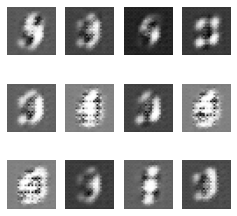

epoch:26
Generator step 0 loss is 1.1559276580810547
Discriminator step 0 loss is 0.8130013346672058
Generator step 1 loss is 1.1647330522537231
Discriminator step 1 loss is 0.7743447422981262
Generator step 2 loss is 1.1734508275985718
Discriminator step 2 loss is 0.7828519344329834
Generator step 3 loss is 1.2213048934936523
Discriminator step 3 loss is 0.7891225218772888
Generator step 4 loss is 1.2521255016326904
Discriminator step 4 loss is 0.714063286781311
Generator step 5 loss is 1.3226423263549805
Discriminator step 5 loss is 0.6785520315170288
Generator step 6 loss is 1.3061344623565674
Discriminator step 6 loss is 0.7119491100311279
Generator step 7 loss is 1.311539888381958
Discriminator step 7 loss is 0.6938510537147522
Generator step 8 loss is 1.3603506088256836
Discriminator step 8 loss is 0.6382662057876587
Generator step 9 loss is 1.3253934383392334
Discriminator step 9 loss is 0.6452784538269043
Generator step 10 loss is 1.2695735692977905
Discriminator step 10 loss i

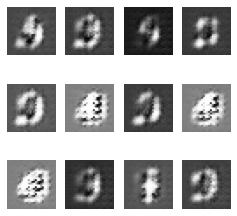

epoch:27
Generator step 0 loss is 1.0581494569778442
Discriminator step 0 loss is 0.8643174767494202
Generator step 1 loss is 1.0743051767349243
Discriminator step 1 loss is 0.8500420451164246
Generator step 2 loss is 1.099565029144287
Discriminator step 2 loss is 0.8278089761734009
Generator step 3 loss is 1.1340783834457397
Discriminator step 3 loss is 0.8218470811843872
Generator step 4 loss is 1.1555917263031006
Discriminator step 4 loss is 0.8266546130180359
Generator step 5 loss is 1.1460177898406982
Discriminator step 5 loss is 0.8240208625793457
Generator step 6 loss is 1.1621060371398926
Discriminator step 6 loss is 0.8244408965110779
Generator step 7 loss is 1.1746193170547485
Discriminator step 7 loss is 0.8012038469314575
Generator step 8 loss is 1.1629018783569336
Discriminator step 8 loss is 0.8238566517829895
Generator step 9 loss is 1.1537542343139648
Discriminator step 9 loss is 0.8100964426994324
Generator step 10 loss is 1.1361052989959717
Discriminator step 10 loss 

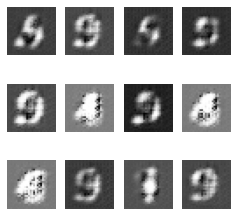

epoch:28
Generator step 0 loss is 1.1338379383087158
Discriminator step 0 loss is 0.9410343170166016
Generator step 1 loss is 1.1338677406311035
Discriminator step 1 loss is 0.9340518712997437
Generator step 2 loss is 1.1165180206298828
Discriminator step 2 loss is 0.9387151598930359
Generator step 3 loss is 1.0924111604690552
Discriminator step 3 loss is 0.9839169979095459
Generator step 4 loss is 1.071786642074585
Discriminator step 4 loss is 0.9799443483352661
Generator step 5 loss is 1.0588688850402832
Discriminator step 5 loss is 0.9657653570175171
Generator step 6 loss is 1.0629719495773315
Discriminator step 6 loss is 1.0038695335388184
Generator step 7 loss is 1.0383810997009277
Discriminator step 7 loss is 0.9782429933547974
Generator step 8 loss is 1.0641279220581055
Discriminator step 8 loss is 0.9654879570007324
Generator step 9 loss is 1.0871316194534302
Discriminator step 9 loss is 0.9580493569374084
Generator step 10 loss is 1.1190263032913208
Discriminator step 10 loss 

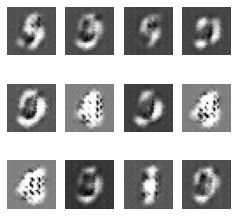

epoch:29
Generator step 0 loss is 1.2108372449874878
Discriminator step 0 loss is 0.6499408483505249
Generator step 1 loss is 1.037939429283142
Discriminator step 1 loss is 0.716537594795227
Generator step 2 loss is 1.0210896730422974
Discriminator step 2 loss is 0.7522971630096436
Generator step 3 loss is 1.08937406539917
Discriminator step 3 loss is 0.7497898936271667
Generator step 4 loss is 1.1922667026519775
Discriminator step 4 loss is 0.8247694969177246
Generator step 5 loss is 1.265343427658081
Discriminator step 5 loss is 0.8297094106674194
Generator step 6 loss is 1.276082992553711
Discriminator step 6 loss is 0.863908052444458
Generator step 7 loss is 1.197568655014038
Discriminator step 7 loss is 0.9261319637298584
Generator step 8 loss is 1.0954008102416992
Discriminator step 8 loss is 0.9642167091369629
Generator step 9 loss is 0.943861722946167
Discriminator step 9 loss is 0.9932823181152344
Generator step 10 loss is 0.8789065480232239
Discriminator step 10 loss is 1.021

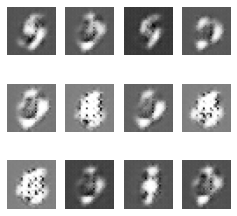

epoch:30
Generator step 0 loss is 1.3957245349884033
Discriminator step 0 loss is 0.5768667459487915
Generator step 1 loss is 1.4748153686523438
Discriminator step 1 loss is 0.5991511344909668
Generator step 2 loss is 1.4947813749313354
Discriminator step 2 loss is 0.5818153619766235
Generator step 3 loss is 1.5232897996902466
Discriminator step 3 loss is 0.5787310600280762
Generator step 4 loss is 1.5274698734283447
Discriminator step 4 loss is 0.6157273054122925
Generator step 5 loss is 1.449306845664978
Discriminator step 5 loss is 0.6092941761016846
Generator step 6 loss is 1.4137935638427734
Discriminator step 6 loss is 0.6323525905609131
Generator step 7 loss is 1.3567689657211304
Discriminator step 7 loss is 0.6270788311958313
Generator step 8 loss is 1.336476445198059
Discriminator step 8 loss is 0.6746646165847778
Generator step 9 loss is 1.2696319818496704
Discriminator step 9 loss is 0.6796562671661377
Generator step 10 loss is 1.2958160638809204
Discriminator step 10 loss i

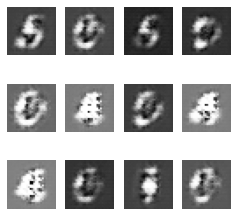

epoch:31
Generator step 0 loss is 1.2388187646865845
Discriminator step 0 loss is 0.7788931131362915
Generator step 1 loss is 1.1948776245117188
Discriminator step 1 loss is 0.7606852054595947
Generator step 2 loss is 1.1242843866348267
Discriminator step 2 loss is 0.7553672790527344
Generator step 3 loss is 1.1044560670852661
Discriminator step 3 loss is 0.7335121035575867
Generator step 4 loss is 1.100721836090088
Discriminator step 4 loss is 0.7334792017936707
Generator step 5 loss is 1.1634016036987305
Discriminator step 5 loss is 0.7396655082702637
Generator step 6 loss is 1.2061753273010254
Discriminator step 6 loss is 0.74068284034729
Generator step 7 loss is 1.2728707790374756
Discriminator step 7 loss is 0.7196011543273926
Generator step 8 loss is 1.2294303178787231
Discriminator step 8 loss is 0.7493550777435303
Generator step 9 loss is 1.2049601078033447
Discriminator step 9 loss is 0.745070219039917
Generator step 10 loss is 1.1609468460083008
Discriminator step 10 loss is 

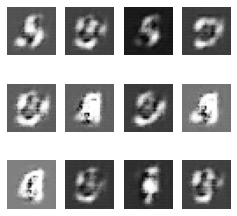

epoch:32
Generator step 0 loss is 1.2649922370910645
Discriminator step 0 loss is 0.7532251477241516
Generator step 1 loss is 1.2805993556976318
Discriminator step 1 loss is 0.7645009160041809
Generator step 2 loss is 1.2876626253128052
Discriminator step 2 loss is 0.7943594455718994
Generator step 3 loss is 1.2517735958099365
Discriminator step 3 loss is 0.7475773692131042
Generator step 4 loss is 1.2178280353546143
Discriminator step 4 loss is 0.7871519327163696
Generator step 5 loss is 1.1781195402145386
Discriminator step 5 loss is 0.7639369964599609
Generator step 6 loss is 1.1757042407989502
Discriminator step 6 loss is 0.7783670425415039
Generator step 7 loss is 1.2004797458648682
Discriminator step 7 loss is 0.7779513597488403
Generator step 8 loss is 1.2375092506408691
Discriminator step 8 loss is 0.7555081844329834
Generator step 9 loss is 1.256425142288208
Discriminator step 9 loss is 0.778243362903595
Generator step 10 loss is 1.261467456817627
Discriminator step 10 loss is

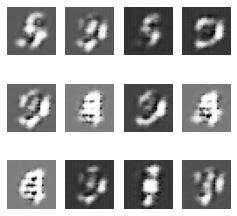

epoch:33
Generator step 0 loss is 1.533522129058838
Discriminator step 0 loss is 0.6347184181213379
Generator step 1 loss is 1.5167231559753418
Discriminator step 1 loss is 0.6047662496566772
Generator step 2 loss is 1.494835615158081
Discriminator step 2 loss is 0.5860627889633179
Generator step 3 loss is 1.4382885694503784
Discriminator step 3 loss is 0.591921329498291
Generator step 4 loss is 1.3941709995269775
Discriminator step 4 loss is 0.5782874822616577
Generator step 5 loss is 1.4988131523132324
Discriminator step 5 loss is 0.5968815684318542
Generator step 6 loss is 1.480947494506836
Discriminator step 6 loss is 0.5550006628036499
Generator step 7 loss is 1.4781616926193237
Discriminator step 7 loss is 0.5633037090301514
Generator step 8 loss is 1.5304796695709229
Discriminator step 8 loss is 0.5663957595825195
Generator step 9 loss is 1.5149188041687012
Discriminator step 9 loss is 0.5708118677139282
Generator step 10 loss is 1.4974160194396973
Discriminator step 10 loss is 

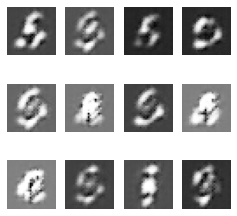

epoch:34
Generator step 0 loss is 1.2098697423934937
Discriminator step 0 loss is 0.8618955612182617
Generator step 1 loss is 1.2080663442611694
Discriminator step 1 loss is 0.884761393070221
Generator step 2 loss is 1.172587513923645
Discriminator step 2 loss is 0.8469429016113281
Generator step 3 loss is 1.0656346082687378
Discriminator step 3 loss is 0.8380069732666016
Generator step 4 loss is 1.0905914306640625
Discriminator step 4 loss is 0.8040709495544434
Generator step 5 loss is 1.1202501058578491
Discriminator step 5 loss is 0.7917932868003845
Generator step 6 loss is 1.2041256427764893
Discriminator step 6 loss is 0.8107678294181824
Generator step 7 loss is 1.239914894104004
Discriminator step 7 loss is 0.8054474592208862
Generator step 8 loss is 1.2581708431243896
Discriminator step 8 loss is 0.7700697779655457
Generator step 9 loss is 1.2414588928222656
Discriminator step 9 loss is 0.7386146187782288
Generator step 10 loss is 1.197222113609314
Discriminator step 10 loss is 

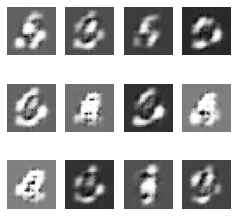

epoch:35
Generator step 0 loss is 1.380995512008667
Discriminator step 0 loss is 0.7131348848342896
Generator step 1 loss is 1.3665838241577148
Discriminator step 1 loss is 0.7048913836479187
Generator step 2 loss is 1.3595081567764282
Discriminator step 2 loss is 0.6945669054985046
Generator step 3 loss is 1.3251776695251465
Discriminator step 3 loss is 0.7287937998771667
Generator step 4 loss is 1.3106297254562378
Discriminator step 4 loss is 0.6977497339248657
Generator step 5 loss is 1.2503669261932373
Discriminator step 5 loss is 0.68189537525177
Generator step 6 loss is 1.304566740989685
Discriminator step 6 loss is 0.6926923990249634
Generator step 7 loss is 1.3728232383728027
Discriminator step 7 loss is 0.645289957523346
Generator step 8 loss is 1.4886345863342285
Discriminator step 8 loss is 0.6440017223358154
Generator step 9 loss is 1.5335912704467773
Discriminator step 9 loss is 0.6600204706192017
Generator step 10 loss is 1.452844500541687
Discriminator step 10 loss is 0.

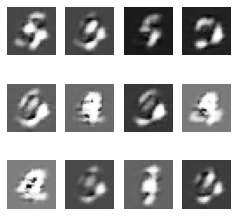

epoch:36
Generator step 0 loss is 1.2916878461837769
Discriminator step 0 loss is 0.715661346912384
Generator step 1 loss is 1.2309315204620361
Discriminator step 1 loss is 0.7416342496871948
Generator step 2 loss is 1.1732525825500488
Discriminator step 2 loss is 0.7323549389839172
Generator step 3 loss is 1.146863579750061
Discriminator step 3 loss is 0.7143390774726868
Generator step 4 loss is 1.222749948501587
Discriminator step 4 loss is 0.764188826084137
Generator step 5 loss is 1.2767558097839355
Discriminator step 5 loss is 0.6977381706237793
Generator step 6 loss is 1.3053394556045532
Discriminator step 6 loss is 0.7490426301956177
Generator step 7 loss is 1.3267349004745483
Discriminator step 7 loss is 0.6805090308189392
Generator step 8 loss is 1.267421007156372
Discriminator step 8 loss is 0.7171216011047363
Generator step 9 loss is 1.2290098667144775
Discriminator step 9 loss is 0.6781944036483765
Generator step 10 loss is 1.257298231124878
Discriminator step 10 loss is 0.

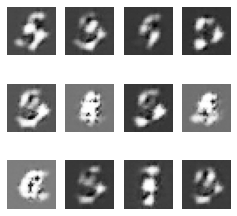

epoch:37
Generator step 0 loss is 1.297942042350769
Discriminator step 0 loss is 0.6393821239471436
Generator step 1 loss is 1.3088347911834717
Discriminator step 1 loss is 0.6371123194694519
Generator step 2 loss is 1.4496862888336182
Discriminator step 2 loss is 0.6548832654953003
Generator step 3 loss is 1.4351015090942383
Discriminator step 3 loss is 0.6712003946304321
Generator step 4 loss is 1.3682252168655396
Discriminator step 4 loss is 0.6420300006866455
Generator step 5 loss is 1.3163403272628784
Discriminator step 5 loss is 0.6361223459243774
Generator step 6 loss is 1.2958123683929443
Discriminator step 6 loss is 0.6887469291687012
Generator step 7 loss is 1.3244903087615967
Discriminator step 7 loss is 0.7223067283630371
Generator step 8 loss is 1.2894198894500732
Discriminator step 8 loss is 0.7020034193992615
Generator step 9 loss is 1.2879117727279663
Discriminator step 9 loss is 0.6572368144989014
Generator step 10 loss is 1.2643733024597168
Discriminator step 10 loss 

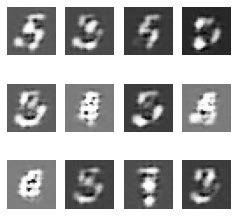

epoch:38
Generator step 0 loss is 1.481945276260376
Discriminator step 0 loss is 0.6630585193634033
Generator step 1 loss is 1.5167185068130493
Discriminator step 1 loss is 0.6531363725662231
Generator step 2 loss is 1.4603180885314941
Discriminator step 2 loss is 0.5944987535476685
Generator step 3 loss is 1.3720142841339111
Discriminator step 3 loss is 0.6373628377914429
Generator step 4 loss is 1.395249843597412
Discriminator step 4 loss is 0.6000983715057373
Generator step 5 loss is 1.45771062374115
Discriminator step 5 loss is 0.6234556436538696
Generator step 6 loss is 1.5111464262008667
Discriminator step 6 loss is 0.5967175960540771
Generator step 7 loss is 1.5393846035003662
Discriminator step 7 loss is 0.5586881637573242
Generator step 8 loss is 1.4910688400268555
Discriminator step 8 loss is 0.5963277816772461
Generator step 9 loss is 1.475778341293335
Discriminator step 9 loss is 0.56400066614151
Generator step 10 loss is 1.497624158859253
Discriminator step 10 loss is 0.60

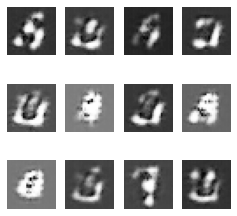

epoch:39
Generator step 0 loss is 1.261329174041748
Discriminator step 0 loss is 0.7385208606719971
Generator step 1 loss is 1.321944236755371
Discriminator step 1 loss is 0.6818225383758545
Generator step 2 loss is 1.371379017829895
Discriminator step 2 loss is 0.7517363429069519
Generator step 3 loss is 1.3598301410675049
Discriminator step 3 loss is 0.7355955243110657
Generator step 4 loss is 1.2207072973251343
Discriminator step 4 loss is 0.7141926288604736
Generator step 5 loss is 1.163478136062622
Discriminator step 5 loss is 0.7649245262145996
Generator step 6 loss is 1.2210041284561157
Discriminator step 6 loss is 0.7158187627792358
Generator step 7 loss is 1.3493249416351318
Discriminator step 7 loss is 0.7013698816299438
Generator step 8 loss is 1.408469796180725
Discriminator step 8 loss is 0.711560845375061
Generator step 9 loss is 1.4177225828170776
Discriminator step 9 loss is 0.6736036539077759
Generator step 10 loss is 1.353898286819458
Discriminator step 10 loss is 0.6

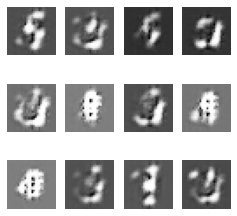

epoch:40
Generator step 0 loss is 1.6211689710617065
Discriminator step 0 loss is 0.5044072270393372
Generator step 1 loss is 1.6468387842178345
Discriminator step 1 loss is 0.5423982739448547
Generator step 2 loss is 1.6977216005325317
Discriminator step 2 loss is 0.5196634531021118
Generator step 3 loss is 1.6348990201950073
Discriminator step 3 loss is 0.5636658668518066
Generator step 4 loss is 1.5724685192108154
Discriminator step 4 loss is 0.5613205432891846
Generator step 5 loss is 1.5586841106414795
Discriminator step 5 loss is 0.5557194948196411
Generator step 6 loss is 1.5003551244735718
Discriminator step 6 loss is 0.5242204666137695
Generator step 7 loss is 1.5761324167251587
Discriminator step 7 loss is 0.5687811374664307
Generator step 8 loss is 1.6573578119277954
Discriminator step 8 loss is 0.6083009243011475
Generator step 9 loss is 1.6078931093215942
Discriminator step 9 loss is 0.5553397536277771
Generator step 10 loss is 1.5571837425231934
Discriminator step 10 loss

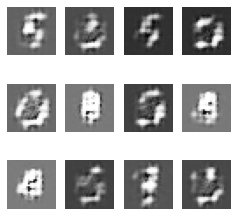

epoch:41
Generator step 0 loss is 1.4897871017456055
Discriminator step 0 loss is 0.6196882724761963
Generator step 1 loss is 1.5952787399291992
Discriminator step 1 loss is 0.6766555905342102
Generator step 2 loss is 1.5033328533172607
Discriminator step 2 loss is 0.6651246547698975
Generator step 3 loss is 1.4171088933944702
Discriminator step 3 loss is 0.6223302483558655
Generator step 4 loss is 1.3334715366363525
Discriminator step 4 loss is 0.6183302402496338
Generator step 5 loss is 1.3638368844985962
Discriminator step 5 loss is 0.6357316970825195
Generator step 6 loss is 1.5413882732391357
Discriminator step 6 loss is 0.6524313688278198
Generator step 7 loss is 1.6082806587219238
Discriminator step 7 loss is 0.6404099464416504
Generator step 8 loss is 1.5919103622436523
Discriminator step 8 loss is 0.5780527591705322
Generator step 9 loss is 1.517242193222046
Discriminator step 9 loss is 0.591895580291748
Generator step 10 loss is 1.4337859153747559
Discriminator step 10 loss i

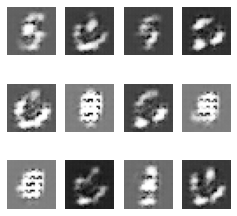

epoch:42
Generator step 0 loss is 1.4560601711273193
Discriminator step 0 loss is 0.5333716869354248
Generator step 1 loss is 1.3905746936798096
Discriminator step 1 loss is 0.5593190789222717
Generator step 2 loss is 1.548962116241455
Discriminator step 2 loss is 0.5148699283599854
Generator step 3 loss is 1.7463845014572144
Discriminator step 3 loss is 0.4937213957309723
Generator step 4 loss is 1.9499976634979248
Discriminator step 4 loss is 0.5011526346206665
Generator step 5 loss is 1.8937557935714722
Discriminator step 5 loss is 0.562519907951355
Generator step 6 loss is 1.6082969903945923
Discriminator step 6 loss is 0.5162073373794556
Generator step 7 loss is 1.489905595779419
Discriminator step 7 loss is 0.5396974682807922
Generator step 8 loss is 1.5284030437469482
Discriminator step 8 loss is 0.5051506757736206
Generator step 9 loss is 1.7110826969146729
Discriminator step 9 loss is 0.5336329340934753
Generator step 10 loss is 1.82957923412323
Discriminator step 10 loss is 0

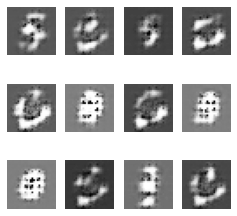

epoch:43
Generator step 0 loss is 2.1330044269561768
Discriminator step 0 loss is 0.41762489080429077
Generator step 1 loss is 2.116446018218994
Discriminator step 1 loss is 0.39168259501457214
Generator step 2 loss is 1.9841315746307373
Discriminator step 2 loss is 0.42943406105041504
Generator step 3 loss is 1.7831199169158936
Discriminator step 3 loss is 0.422250896692276
Generator step 4 loss is 1.709248423576355
Discriminator step 4 loss is 0.4072430729866028
Generator step 5 loss is 1.816320538520813
Discriminator step 5 loss is 0.3911896347999573
Generator step 6 loss is 1.9905701875686646
Discriminator step 6 loss is 0.41560155153274536
Generator step 7 loss is 2.0674476623535156
Discriminator step 7 loss is 0.378997802734375
Generator step 8 loss is 2.1934821605682373
Discriminator step 8 loss is 0.39567190408706665
Generator step 9 loss is 2.0525007247924805
Discriminator step 9 loss is 0.42387068271636963
Generator step 10 loss is 2.00327205657959
Discriminator step 10 loss 

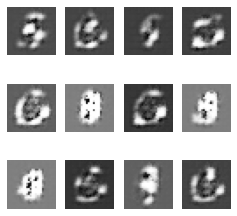

epoch:44
Generator step 0 loss is 1.6736053228378296
Discriminator step 0 loss is 0.4999902546405792
Generator step 1 loss is 1.7034246921539307
Discriminator step 1 loss is 0.5068881511688232
Generator step 2 loss is 1.5823686122894287
Discriminator step 2 loss is 0.5014655590057373
Generator step 3 loss is 1.5283126831054688
Discriminator step 3 loss is 0.49794840812683105
Generator step 4 loss is 1.546739101409912
Discriminator step 4 loss is 0.4990396499633789
Generator step 5 loss is 1.7463678121566772
Discriminator step 5 loss is 0.47241780161857605
Generator step 6 loss is 1.8033775091171265
Discriminator step 6 loss is 0.4864599406719208
Generator step 7 loss is 1.7657829523086548
Discriminator step 7 loss is 0.5174137353897095
Generator step 8 loss is 1.6154468059539795
Discriminator step 8 loss is 0.5058690309524536
Generator step 9 loss is 1.5646072626113892
Discriminator step 9 loss is 0.5025582313537598
Generator step 10 loss is 1.5761851072311401
Discriminator step 10 los

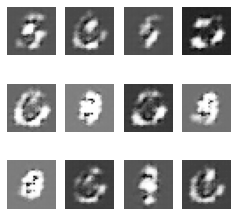

epoch:45
Generator step 0 loss is 1.520442247390747
Discriminator step 0 loss is 0.5298776626586914
Generator step 1 loss is 1.4550654888153076
Discriminator step 1 loss is 0.5312579870223999
Generator step 2 loss is 1.6502361297607422
Discriminator step 2 loss is 0.5040184855461121
Generator step 3 loss is 1.8835505247116089
Discriminator step 3 loss is 0.5726882219314575
Generator step 4 loss is 1.8518985509872437
Discriminator step 4 loss is 0.5387566685676575
Generator step 5 loss is 1.6095227003097534
Discriminator step 5 loss is 0.5264571905136108
Generator step 6 loss is 1.4641826152801514
Discriminator step 6 loss is 0.5163733959197998
Generator step 7 loss is 1.5464363098144531
Discriminator step 7 loss is 0.518200159072876
Generator step 8 loss is 1.6948745250701904
Discriminator step 8 loss is 0.4915052056312561
Generator step 9 loss is 1.7711377143859863
Discriminator step 9 loss is 0.5273401141166687
Generator step 10 loss is 1.804527759552002
Discriminator step 10 loss is

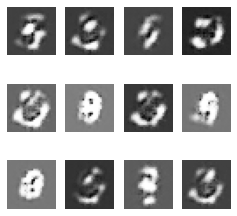

epoch:46
Generator step 0 loss is 1.8591827154159546
Discriminator step 0 loss is 0.49801111221313477
Generator step 1 loss is 1.9318698644638062
Discriminator step 1 loss is 0.4755398631095886
Generator step 2 loss is 1.736183762550354
Discriminator step 2 loss is 0.4716498851776123
Generator step 3 loss is 1.6973457336425781
Discriminator step 3 loss is 0.47880467772483826
Generator step 4 loss is 1.6115105152130127
Discriminator step 4 loss is 0.47329938411712646
Generator step 5 loss is 1.6938313245773315
Discriminator step 5 loss is 0.5221996307373047
Generator step 6 loss is 1.7021853923797607
Discriminator step 6 loss is 0.5188978314399719
Generator step 7 loss is 1.704554557800293
Discriminator step 7 loss is 0.519368052482605
Generator step 8 loss is 1.6175134181976318
Discriminator step 8 loss is 0.5070828795433044
Generator step 9 loss is 1.6382532119750977
Discriminator step 9 loss is 0.519917368888855
Generator step 10 loss is 1.6818994283676147
Discriminator step 10 loss 

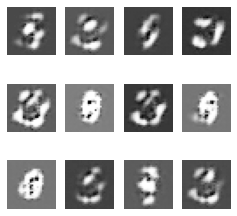

epoch:47
Generator step 0 loss is 1.409072995185852
Discriminator step 0 loss is 0.5057421326637268
Generator step 1 loss is 1.4908146858215332
Discriminator step 1 loss is 0.47361311316490173
Generator step 2 loss is 1.7297616004943848
Discriminator step 2 loss is 0.45096176862716675
Generator step 3 loss is 2.0414977073669434
Discriminator step 3 loss is 0.4575546085834503
Generator step 4 loss is 2.0002734661102295
Discriminator step 4 loss is 0.5317720174789429
Generator step 5 loss is 1.6698400974273682
Discriminator step 5 loss is 0.47175079584121704
Generator step 6 loss is 1.4304953813552856
Discriminator step 6 loss is 0.5004041790962219
Generator step 7 loss is 1.4822869300842285
Discriminator step 7 loss is 0.44664472341537476
Generator step 8 loss is 1.8142147064208984
Discriminator step 8 loss is 0.4628363251686096
Generator step 9 loss is 2.0333609580993652
Discriminator step 9 loss is 0.4366949796676636
Generator step 10 loss is 2.132451057434082
Discriminator step 10 lo

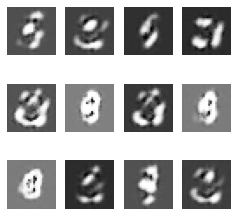

epoch:48
Generator step 0 loss is 1.5243198871612549
Discriminator step 0 loss is 0.5261486172676086
Generator step 1 loss is 1.6399972438812256
Discriminator step 1 loss is 0.4851383864879608
Generator step 2 loss is 1.8414888381958008
Discriminator step 2 loss is 0.5274372100830078
Generator step 3 loss is 1.7580116987228394
Discriminator step 3 loss is 0.505577802658081
Generator step 4 loss is 1.7030984163284302
Discriminator step 4 loss is 0.4707871079444885
Generator step 5 loss is 1.591376781463623
Discriminator step 5 loss is 0.52462238073349
Generator step 6 loss is 1.5470112562179565
Discriminator step 6 loss is 0.5000840425491333
Generator step 7 loss is 1.6076562404632568
Discriminator step 7 loss is 0.5183050632476807
Generator step 8 loss is 1.7807018756866455
Discriminator step 8 loss is 0.48147231340408325
Generator step 9 loss is 1.850685954093933
Discriminator step 9 loss is 0.4992140829563141
Generator step 10 loss is 1.7349865436553955
Discriminator step 10 loss is 

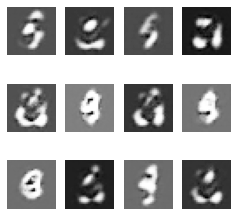

epoch:49
Generator step 0 loss is 1.8408775329589844
Discriminator step 0 loss is 0.4983568489551544
Generator step 1 loss is 1.8154335021972656
Discriminator step 1 loss is 0.47884294390678406
Generator step 2 loss is 1.7370860576629639
Discriminator step 2 loss is 0.5041671395301819
Generator step 3 loss is 1.6515053510665894
Discriminator step 3 loss is 0.4801798462867737
Generator step 4 loss is 1.58906090259552
Discriminator step 4 loss is 0.5230705738067627
Generator step 5 loss is 1.7219573259353638
Discriminator step 5 loss is 0.5082493424415588
Generator step 6 loss is 1.7463210821151733
Discriminator step 6 loss is 0.45514506101608276
Generator step 7 loss is 1.723642110824585
Discriminator step 7 loss is 0.4987330138683319
Generator step 8 loss is 1.677712321281433
Discriminator step 8 loss is 0.4889342188835144
Generator step 9 loss is 1.7141999006271362
Discriminator step 9 loss is 0.52610844373703
Generator step 10 loss is 1.600679636001587
Discriminator step 10 loss is 0

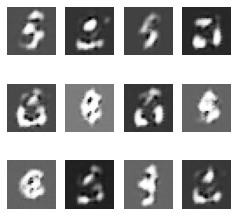

epoch:50
Generator step 0 loss is 1.5993919372558594
Discriminator step 0 loss is 0.47121644020080566
Generator step 1 loss is 1.6652958393096924
Discriminator step 1 loss is 0.4847709536552429
Generator step 2 loss is 1.6999268531799316
Discriminator step 2 loss is 0.4782920479774475
Generator step 3 loss is 1.7941075563430786
Discriminator step 3 loss is 0.4743106961250305
Generator step 4 loss is 1.833540678024292
Discriminator step 4 loss is 0.4440971612930298
Generator step 5 loss is 1.8061323165893555
Discriminator step 5 loss is 0.460188090801239
Generator step 6 loss is 1.6836392879486084
Discriminator step 6 loss is 0.4636183977127075
Generator step 7 loss is 1.720210313796997
Discriminator step 7 loss is 0.47011470794677734
Generator step 8 loss is 1.8312432765960693
Discriminator step 8 loss is 0.4390066862106323
Generator step 9 loss is 1.8494518995285034
Discriminator step 9 loss is 0.43167394399642944
Generator step 10 loss is 1.7836201190948486
Discriminator step 10 loss

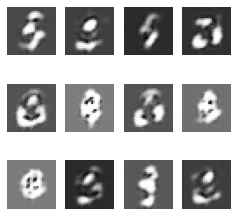

epoch:51
Generator step 0 loss is 1.6105669736862183
Discriminator step 0 loss is 0.4651714563369751
Generator step 1 loss is 1.731249213218689
Discriminator step 1 loss is 0.4739888608455658
Generator step 2 loss is 1.8831474781036377
Discriminator step 2 loss is 0.46528634428977966
Generator step 3 loss is 1.770708680152893
Discriminator step 3 loss is 0.4734615683555603
Generator step 4 loss is 1.6402671337127686
Discriminator step 4 loss is 0.5061689615249634
Generator step 5 loss is 1.630399465560913
Discriminator step 5 loss is 0.4619261622428894
Generator step 6 loss is 1.7094039916992188
Discriminator step 6 loss is 0.4723678231239319
Generator step 7 loss is 1.829374074935913
Discriminator step 7 loss is 0.4433620572090149
Generator step 8 loss is 1.8487823009490967
Discriminator step 8 loss is 0.4446718096733093
Generator step 9 loss is 1.8394596576690674
Discriminator step 9 loss is 0.4478517770767212
Generator step 10 loss is 1.7655888795852661
Discriminator step 10 loss is

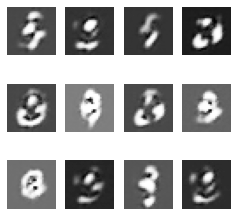

epoch:52
Generator step 0 loss is 1.8139454126358032
Discriminator step 0 loss is 0.44165730476379395
Generator step 1 loss is 1.9155908823013306
Discriminator step 1 loss is 0.43375521898269653
Generator step 2 loss is 1.7646996974945068
Discriminator step 2 loss is 0.44610312581062317
Generator step 3 loss is 1.6968764066696167
Discriminator step 3 loss is 0.44776028394699097
Generator step 4 loss is 1.6664619445800781
Discriminator step 4 loss is 0.4780590534210205
Generator step 5 loss is 1.7573015689849854
Discriminator step 5 loss is 0.4356224536895752
Generator step 6 loss is 1.7397143840789795
Discriminator step 6 loss is 0.46397411823272705
Generator step 7 loss is 1.786062240600586
Discriminator step 7 loss is 0.4817710220813751
Generator step 8 loss is 1.7775074243545532
Discriminator step 8 loss is 0.4814571440219879
Generator step 9 loss is 1.5800718069076538
Discriminator step 9 loss is 0.47347885370254517
Generator step 10 loss is 1.7233246564865112
Discriminator step 10

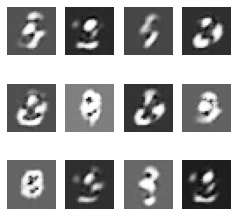

epoch:53
Generator step 0 loss is 1.9490959644317627
Discriminator step 0 loss is 0.4175299406051636
Generator step 1 loss is 1.6765034198760986
Discriminator step 1 loss is 0.42488768696784973
Generator step 2 loss is 1.6948142051696777
Discriminator step 2 loss is 0.4140951931476593
Generator step 3 loss is 1.7426599264144897
Discriminator step 3 loss is 0.4427695572376251
Generator step 4 loss is 2.0017895698547363
Discriminator step 4 loss is 0.4192591905593872
Generator step 5 loss is 1.9143472909927368
Discriminator step 5 loss is 0.4310110807418823
Generator step 6 loss is 1.8815243244171143
Discriminator step 6 loss is 0.4207051396369934
Generator step 7 loss is 1.6251126527786255
Discriminator step 7 loss is 0.42348790168762207
Generator step 8 loss is 1.6555310487747192
Discriminator step 8 loss is 0.420077919960022
Generator step 9 loss is 1.886406660079956
Discriminator step 9 loss is 0.43808281421661377
Generator step 10 loss is 1.8944127559661865
Discriminator step 10 los

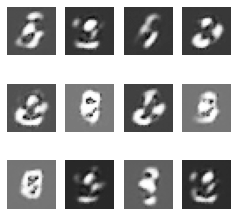

epoch:54
Generator step 0 loss is 1.5585198402404785
Discriminator step 0 loss is 0.47920647263526917
Generator step 1 loss is 1.7361515760421753
Discriminator step 1 loss is 0.4900064170360565
Generator step 2 loss is 1.801269292831421
Discriminator step 2 loss is 0.4513514041900635
Generator step 3 loss is 1.8735480308532715
Discriminator step 3 loss is 0.4431160092353821
Generator step 4 loss is 1.8975404500961304
Discriminator step 4 loss is 0.4427357316017151
Generator step 5 loss is 1.6535494327545166
Discriminator step 5 loss is 0.4777643084526062
Generator step 6 loss is 1.6841368675231934
Discriminator step 6 loss is 0.42563074827194214
Generator step 7 loss is 1.795972466468811
Discriminator step 7 loss is 0.4434228837490082
Generator step 8 loss is 1.968468427658081
Discriminator step 8 loss is 0.4432569146156311
Generator step 9 loss is 1.9295040369033813
Discriminator step 9 loss is 0.43926137685775757
Generator step 10 loss is 1.798695683479309
Discriminator step 10 loss 

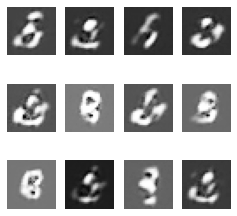

epoch:55
Generator step 0 loss is 2.19264817237854
Discriminator step 0 loss is 0.4184049367904663
Generator step 1 loss is 2.0820162296295166
Discriminator step 1 loss is 0.40484049916267395
Generator step 2 loss is 1.8770440816879272
Discriminator step 2 loss is 0.41063976287841797
Generator step 3 loss is 1.559217095375061
Discriminator step 3 loss is 0.4330846071243286
Generator step 4 loss is 1.7735017538070679
Discriminator step 4 loss is 0.4160500168800354
Generator step 5 loss is 2.0741610527038574
Discriminator step 5 loss is 0.40778467059135437
Generator step 6 loss is 2.0904057025909424
Discriminator step 6 loss is 0.4310775399208069
Generator step 7 loss is 1.930416226387024
Discriminator step 7 loss is 0.43133634328842163
Generator step 8 loss is 1.7246593236923218
Discriminator step 8 loss is 0.4158274531364441
Generator step 9 loss is 1.7632900476455688
Discriminator step 9 loss is 0.38484612107276917
Generator step 10 loss is 1.8753063678741455
Discriminator step 10 los

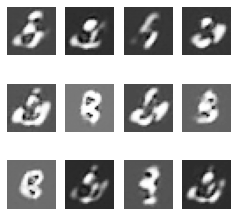

epoch:56
Generator step 0 loss is 2.3188765048980713
Discriminator step 0 loss is 0.4076632261276245
Generator step 1 loss is 2.178224563598633
Discriminator step 1 loss is 0.42400139570236206
Generator step 2 loss is 1.6912741661071777
Discriminator step 2 loss is 0.43327099084854126
Generator step 3 loss is 1.6014459133148193
Discriminator step 3 loss is 0.4402933120727539
Generator step 4 loss is 1.7529380321502686
Discriminator step 4 loss is 0.4153810143470764
Generator step 5 loss is 2.1645193099975586
Discriminator step 5 loss is 0.4303918778896332
Generator step 6 loss is 2.2424423694610596
Discriminator step 6 loss is 0.42557480931282043
Generator step 7 loss is 1.910172939300537
Discriminator step 7 loss is 0.397064208984375
Generator step 8 loss is 1.750604510307312
Discriminator step 8 loss is 0.4080125689506531
Generator step 9 loss is 1.7316516637802124
Discriminator step 9 loss is 0.41184014081954956
Generator step 10 loss is 2.019894599914551
Discriminator step 10 loss 

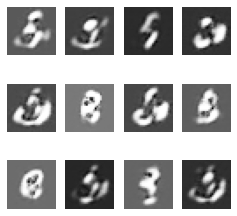

epoch:57
Generator step 0 loss is 1.8218598365783691
Discriminator step 0 loss is 0.4148523211479187
Generator step 1 loss is 1.833903431892395
Discriminator step 1 loss is 0.4539022445678711
Generator step 2 loss is 1.9089734554290771
Discriminator step 2 loss is 0.42809557914733887
Generator step 3 loss is 2.074695587158203
Discriminator step 3 loss is 0.46015655994415283
Generator step 4 loss is 1.8577250242233276
Discriminator step 4 loss is 0.3821546137332916
Generator step 5 loss is 1.8874448537826538
Discriminator step 5 loss is 0.41761094331741333
Generator step 6 loss is 1.9133048057556152
Discriminator step 6 loss is 0.41831088066101074
Generator step 7 loss is 2.002833366394043
Discriminator step 7 loss is 0.45741045475006104
Generator step 8 loss is 1.8627371788024902
Discriminator step 8 loss is 0.40670591592788696
Generator step 9 loss is 1.8814680576324463
Discriminator step 9 loss is 0.41493842005729675
Generator step 10 loss is 1.9761699438095093
Discriminator step 10 

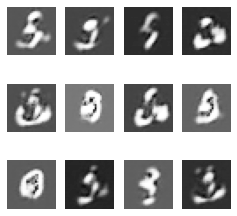

epoch:58
Generator step 0 loss is 1.9569783210754395
Discriminator step 0 loss is 0.41853344440460205
Generator step 1 loss is 1.876827597618103
Discriminator step 1 loss is 0.40659427642822266
Generator step 2 loss is 1.8249115943908691
Discriminator step 2 loss is 0.410408616065979
Generator step 3 loss is 1.883163571357727
Discriminator step 3 loss is 0.41648662090301514
Generator step 4 loss is 1.897994041442871
Discriminator step 4 loss is 0.4537166953086853
Generator step 5 loss is 1.7585036754608154
Discriminator step 5 loss is 0.44669443368911743
Generator step 6 loss is 1.8125994205474854
Discriminator step 6 loss is 0.4215148687362671
Generator step 7 loss is 1.9456228017807007
Discriminator step 7 loss is 0.44496554136276245
Generator step 8 loss is 1.7342371940612793
Discriminator step 8 loss is 0.44493287801742554
Generator step 9 loss is 1.8124260902404785
Discriminator step 9 loss is 0.42970699071884155
Generator step 10 loss is 1.9554598331451416
Discriminator step 10 l

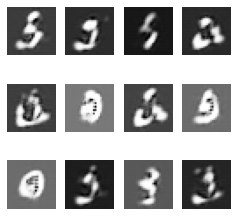

epoch:59
Generator step 0 loss is 2.2893002033233643
Discriminator step 0 loss is 0.33619481325149536
Generator step 1 loss is 2.193549871444702
Discriminator step 1 loss is 0.36557477712631226
Generator step 2 loss is 1.819070816040039
Discriminator step 2 loss is 0.3441848158836365
Generator step 3 loss is 1.7212337255477905
Discriminator step 3 loss is 0.3567102253437042
Generator step 4 loss is 2.013115882873535
Discriminator step 4 loss is 0.3520265519618988
Generator step 5 loss is 2.2798662185668945
Discriminator step 5 loss is 0.3906765878200531
Generator step 6 loss is 2.215777635574341
Discriminator step 6 loss is 0.33826011419296265
Generator step 7 loss is 1.884417176246643
Discriminator step 7 loss is 0.35296630859375
Generator step 8 loss is 1.810318112373352
Discriminator step 8 loss is 0.3651960492134094
Generator step 9 loss is 1.9971704483032227
Discriminator step 9 loss is 0.3311880826950073
Generator step 10 loss is 2.2654049396514893
Discriminator step 10 loss is 0

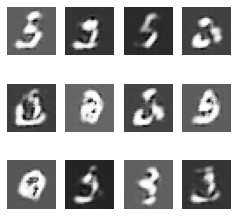

In [57]:
train(x_train, epochs)   #模型训练